In [1]:
import numpy as np


In [2]:


SK = {
    ('s', 's'): lambda l, m, n, V: V['ss'],
    ('s', 'px'): lambda l, m, n, V:  l * V['sp'],
    ('px', 's'): lambda l, m, n, V: -l * V['sp'],

    ('s', 'py'): lambda l, m, n, V:  m * V['sp'],
    ('py', 's'): lambda l, m, n, V: -m * V['sp'],

    ('s', 'pz'): lambda l, m, n, V:  n * V['sp'],
    ('pz', 's'): lambda l, m, n, V: -n * V['sp'],

    ('px', 'px'): lambda l, m, n, V: l**2 * V['pp_sigma'] + (1 - l**2) * V['pp_pi'],
    ('py', 'py'): lambda l, m, n, V: m**2 * V['pp_sigma'] + (1 - m**2) * V['pp_pi'],
    ('pz', 'pz'): lambda l, m, n, V: n**2 * V['pp_sigma'] + (1 - n**2) * V['pp_pi'],

    ('px', 'py'): lambda l, m, n, V: l * m * (V['pp_sigma'] - V['pp_pi']),
    ('px', 'pz'): lambda l, m, n, V: l * n * (V['pp_sigma'] - V['pp_pi']),
    ('py', 'pz'): lambda l, m, n, V: m * n * (V['pp_sigma'] - V['pp_pi']),

    ('py', 'px'): lambda l, m, n, V: l * m * (V['pp_sigma'] - V['pp_pi']),
    ('pz', 'px'): lambda l, m, n, V: l * n * (V['pp_sigma'] - V['pp_pi']),
    ('pz', 'py'): lambda l, m, n, V: m * n * (V['pp_sigma'] - V['pp_pi']),
}

Vss = -8.13
Vsp = 5.88
Vxx=1.71
Vxy=7.51

V_ss_sigma = Vss / 4
V_sp_sigma = np.sqrt(3) / 4 * Vsp
diff1 = Vxx - Vxy
diff2 = Vxx
V_pp_pi = diff1 / 4
V_pp_sigma = (Vxy + 4 * V_pp_pi /3) * 3 / 4
a=1

Es,Ep =  -4.03, 3.17
E = {'s': Es, 'px': Ep, 'py': Ep, 'pz': Ep}
V = {
    'ss': V_ss_sigma,
    'sp': V_sp_sigma,
    'pp_sigma': V_pp_sigma,
    'pp_pi': V_pp_pi
}

distance = np.sqrt(3)/4
base_angle = np.sqrt(1/3)
unitCellDict = {
    (0.0, 0.0, 0.0): [ 
        {"neighbor_position": (0.25, 0.25, 0.25), 
         "delta": (0.25, 0.25, 0.25),
         "distance": distance,
         "l":  base_angle, "m":  base_angle, "n":  base_angle},
        {"neighbor_position": (0.25, -0.25, -0.25), 
         "delta": (0.25, -0.25, -0.25),
         "distance": distance,
         "l":  base_angle, "m": -base_angle, "n": -base_angle},
        {"neighbor_position": (-0.25, 0.25, -0.25), 
         "delta": (-0.25, 0.25, -0.25),
         "distance": distance,
         "l": -base_angle, "m":  base_angle, "n": -base_angle},
        {"neighbor_position": (-0.25, -0.25, 0.25), 
         "delta": (-0.25, -0.25, 0.25),
         "distance": distance,
         "l": -base_angle, "m": -base_angle, "n":  base_angle},
    ],
    (0.25, 0.25, 0.25): [
        {"neighbor_position": (0.0, 0.0, 0.0), 
         "delta": (-0.25, -0.25, -0.25),
         "distance": distance,
         "l": -base_angle, "m": -base_angle, "n": -base_angle},
        {"neighbor_position": (0.0, 0.5, 0.5), 
         "delta": (-0.25, 0.25, 0.25),
         "distance": distance,
         "l": -base_angle, "m":  base_angle, "n":  base_angle},
        {"neighbor_position": (0.5, 0.0, 0.5), 
         "delta": (0.25, -0.25, 0.25),
         "distance": distance,
         "l":  base_angle, "m": -base_angle, "n":  base_angle},
        {"neighbor_position": (0.5, 0.5, 0.0), 
         "delta": (0.25, 0.25, -0.25),
         "distance": distance,
         "l":  base_angle, "m":  base_angle, "n": -base_angle},
    ]
}

In [3]:

def create_bulk_tight_binding(k,a=1.0, tol=0.2):
    """
    builds tight binding hamiltonian 
    """
    kx, ky, kz = k
    orbitals = ['s', 'px', 'py', 'pz']
    num_orb = len(orbitals)
    # 8total atoms
    H = np.zeros((8, 8), dtype=complex)
    atoms = sorted(unitCellDict.keys()) 
    
    # On-site energies
    for atom_index, atom_pos in enumerate(atoms):
        for orb_index, orb in enumerate(orbitals):
            i = atom_index * num_orb + orb_index
            H[i, i] = E[orb]
            """if (i == 1 or i == 5):
                H[i,i] += 1.46 * np.cos(k[1]) * np.cos(k[2])""" # second nearest corrections
    
    # Hopping terms
    for atom_index, atom_pos in enumerate(atoms):
        #print("atom: ", atom_index)
        home_pos = np.array(atom_pos)
        neighbors = unitCellDict[atom_pos]
        
        for orb_index, orb in enumerate(orbitals):
            #print("orbindex: ", orb_index)
            i = atom_index * num_orb + orb_index
            
            for neighbor_index, neighbor in enumerate(neighbors):
                #print("neighbor ", neighbor_index, " of atom", atom_index)
                delta = np.array(neighbor["delta"])
                T = delta
                phase = np.exp(1j * (kx*T[0] + ky*T[1] + kz*T[2])) 

                
                # direction cosines
                l_val = neighbor["l"]
                m_val = neighbor["m"]
                n_val = neighbor["n"]
                
                neighbor_atom_index = 1 if atom_index == 0 else 0
                
                # sum over all orbitals on the neighbor atom
                for sec_orb_index, sec_orb in enumerate(orbitals):
                    #print("orbit: ", sec_orb_index, " of neighbor", neighbor_index)
                    j = neighbor_atom_index * num_orb + sec_orb_index
                    #print(i,j)
                    hop = SK[(orb, sec_orb)](l_val, m_val, n_val, V)
                        
                    H[i, j] += hop * phase
                    

    dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(H, dagger(H)):
        print("H isnt Hermitian")
        

    eigvals = np.linalg.eigvalsh(H)
    eigvals.sort()
    return eigvals, H

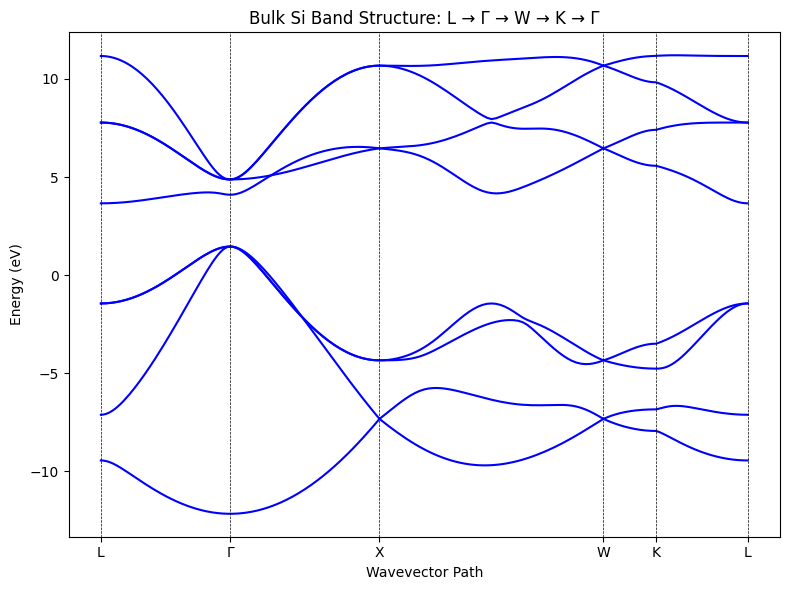

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ===== High-Symmetry Points =====
# Note: These points are typical for an FCC Brillouin zone.

G =  2 * np.pi / a * np.array([0, 0, 0])
L = 2 * np.pi / a *np.array([1/2, 1/2, 1/2])
K = 2 * np.pi / a *np.array([3/4, 3/4, 0])
X = 2 * np.pi / a *np.array([0, 0, 1])
W = 2 * np.pi / a *np.array([1, 1/2, 0])
U = 2 * np.pi / a *np.array([1/4, 1/4, 1])


hs_points = [
    ('L', 2 * np.pi / a * np.array([0.5, 0.5, 0.5])),
    ('Γ', 2 * np.pi / a *np.array([0.0, 0.0, 0.0])),
    ('X', X),
    ('W', W),
    ('K', K),
    ('L',L)
]

def linpath(k_start, k_end, N):
    """Generate N points between k_start and k_end (excluding the endpoint)."""
    return np.linspace(k_start, k_end, N, endpoint=False)


num_points_per_segment = 50  
k_points = []
k_path_dist = []  
hs_labels = []    

# Initialize with the first high-symmetry point.
k_points.append(hs_points[0][1])
k_path_dist.append(0.0)
hs_labels.append((hs_points[0][0], 0.0))

# Loop over segments between high-symmetry points.
for i in range(len(hs_points) - 1):
    label_start, k_start = hs_points[i]
    label_end, k_end = hs_points[i+1]
    segment = linpath(k_start, k_end, num_points_per_segment)
    
    # For each point in the segment, compute the cumulative distance.
    for k in segment:
        # Skip the first point of each segment to avoid duplicates (except for the very first segment)
        if np.allclose(k, k_points[-1]):
            continue
        k_points.append(k)
        # Distance from the previous point
        delta = np.linalg.norm(k - k_points[-2])
        k_path_dist.append(k_path_dist[-1] + delta)
    
    # Mark the high-symmetry endpoint:
    # (Make sure to include the final point of the segment)
    if not np.allclose(k_points[-1], k_end):
        k_points.append(k_end)
        delta = np.linalg.norm(k_end - k_points[-2])
        k_path_dist.append(k_path_dist[-1] + delta)
    hs_labels.append((label_end, k_path_dist[-1]))

# ===== Compute the eigenvalues (bands) along the k-path =====
# Here we assume that create_bulk_tight_binding returns an array of 8 eigenvalues.
bands = []  # Will be a list of eigenvalue arrays

for k in k_points:
    eigvals,H = create_bulk_tight_binding(k, a=1.0, tol=0.2)
    #print(H)
    bands.append(eigvals)
bands = np.array(bands)  # shape: (num_k_points, 8)

# ===== Plot the Band Structure =====
plt.figure(figsize=(8,6))
num_bands = bands.shape[1]
for band in range(num_bands):
    plt.plot(k_path_dist, bands[:, band], 'b-')

# Mark the high-symmetry points on the plot.
hs_positions = [dist for (label, dist) in hs_labels]
hs_names = [label for (label, dist) in hs_labels]
for pos in hs_positions:
    plt.axvline(x=pos, color='k', linestyle='--', linewidth=0.5)
plt.xticks(hs_positions, hs_names)
plt.xlabel("Wavevector Path")
plt.ylabel("Energy (eV)")
plt.title("Bulk Si Band Structure: L → Γ → W → K → Γ")
plt.tight_layout()
plt.show()


In [7]:
import numpy as np

hbar = 1.054_571_817e-34   # J·s
a    = 1.0                 # lattice constant  (same units as TB)
_two_pi_over_a = 2*np.pi/a


def effective_mass_bulk(klen=25, band=None):
    """
    Compute the 3×3 inverse effective-mass tensor at the minimum of `band`
    (default = first conduction band) for a bulk tight-binding Hamiltonian.

    Returns
    -------
    m_tensor   : (3, 3) ndarray   --  effective-mass tensor  [kg]
    curvatures : (3,) ndarray     --  ∂²E/∂k_i² along x,y,z  [energy·length²]
    k_min_idx  : (3,) tuple       --  integer indices (ix,iy,iz) of the minimum
    E_min      : float            --  band minimum energy    [same as TB]
    """

    k_axis = np.linspace(-1, 1, klen) * _two_pi_over_a
    dk     = k_axis[1] - k_axis[0]
    nbands = len(create_bulk_tight_binding(np.zeros(3))[0])

    if band is None:
        band = nbands // 2

    energies = np.empty((klen**3, nbands), dtype=float)

    idx = 0
    for kx in k_axis:
        for ky in k_axis:
            for kz in k_axis:
                energies[idx] = np.sort(create_bulk_tight_binding(
                                         np.array([kx, ky, kz]))[0].real)
                idx += 1

    energies = energies.reshape(klen, klen, klen, nbands)
    band_E   = energies[..., band]          


    ix, iy, iz = np.unravel_index(np.argmin(band_E), band_E.shape)

    if ix in (0, klen-1) or iy in (0, klen-1) or iz in (0, klen-1):
        raise RuntimeError("Band minimum lies on the Brillouin-zone boundary; "
                           "use a PBC-aware derivative or enlarge the mesh.")

    d2E_dk2 = np.zeros(3)
    d2E_dk2[0] = (band_E[ix-1, iy, iz] + band_E[ix+1, iy, iz]
                  - 2*band_E[ix, iy, iz]) / dk**2
    d2E_dk2[1] = (band_E[ix, iy-1, iz] + band_E[ix, iy+1, iz]
                  - 2*band_E[ix, iy, iz]) / dk**2
    d2E_dk2[2] = (band_E[ix, iy, iz-1] + band_E[ix, iy, iz+1]
                  - 2*band_E[ix, iy, iz]) / dk**2


    d2E_dxdy = ( band_E[ix+1, iy+1, iz] + band_E[ix-1, iy-1, iz]
               - band_E[ix+1, iy-1, iz] - band_E[ix-1, iy+1, iz]) / (4*dk**2)
    d2E_dxdz = ( band_E[ix+1, iy, iz+1] + band_E[ix-1, iy, iz-1]
               - band_E[ix+1, iy, iz-1] - band_E[ix-1, iy, iz+1]) / (4*dk**2)
    d2E_dydz = ( band_E[ix, iy+1, iz+1] + band_E[ix, iy-1, iz-1]
               - band_E[ix, iy+1, iz-1] - band_E[ix, iy-1, iz+1]) / (4*dk**2)

    H = np.array([[d2E_dk2[0], d2E_dxdy,   d2E_dxdz],
                  [d2E_dxdy,   d2E_dk2[1], d2E_dydz],
                  [d2E_dxdz,   d2E_dydz,   d2E_dk2[2]]])

    m_inv = H / hbar**2            
    m_tensor = np.linalg.inv(m_inv)

    return m_tensor, H, (ix, iy, iz), band_E[ix, iy, iz]



m_star, curv, k_min_idx, E0 = effective_mass_bulk(klen=25)

print("Minimum energy  :", E0)
print("Minimum @ index :", k_min_idx)
print("Diagonal curvatures ∂²E/∂k_i²  (eV·Å² or your internal units):")
print(np.diag(curv))
print("\nEffective-mass tensor  [kg]:")
print(m_star)


Minimum energy  : 3.6628010356730867
Minimum @ index : (np.int64(6), np.int64(18), np.int64(6))
Diagonal curvatures ∂²E/∂k_i²  (eV·Å² or your internal units):
[0.57146723 0.57146723 0.57146723]

Effective-mass tensor  [kg]:
[[ 3.32553680e-68 -1.89813332e-68  1.89813332e-68]
 [-1.89813332e-68  3.32553680e-68 -1.89813332e-68]
 [ 1.89813332e-68 -1.89813332e-68  3.32553680e-68]]
